In [1]:
using Plots, TaylorSeries
pyplot(legend = :false, grid = :false)

Plots.PyPlotBackend()

In [2]:
const λ = 1.0
const Z = 2.0
const _ordenTaylor = 20
const _epsAbs = 1.0e-20

1.0e-20

In [3]:
# Returns stepsize of the integration and a vector with the updated values of the dependent
# variables
function taylorStepper{T<:Real}( jetEqs::Function, vec0::Array{T,1} )
    
    n = length( vec0 )

    vec0T = Array(Taylor1{T},n)
    @simd for i in eachindex(vec0)
        @inbounds vec0T[i] = Taylor1([vec0[i]], _ordenTaylor)
    end

    # Jets
    vec1T = jetEqs( vec0 )
    
    # Step-size
    hh = Inf
    for i in eachindex(vec1T)
        @inbounds h1 = stepsize( vec1T[i], _epsAbs )
        hh = min( hh, h1 )
    end
    
    # Values at t0+h
    @simd for i in eachindex(vec0)
        @inbounds vec0[i] = evaluate( vec1T[i], hh )
    end
    
    return hh, vec0
end

# Returns the maximum step size from epsilon and the last two coefficients of the x-Taylor series 
function stepsize{T<:Real}(x::Taylor1{T}, epsilon::Float64)
    ord = x.order
    h = Inf
    for k in [ord-1, ord]
        kinv = 1.0/k
        aux = abs( x.coeffs[k+1] )
        h = min(h, (epsilon/aux)^kinv)
    end
    return h
end

stepsize (generic function with 1 method)

Aquí implementaremos el hamiltoniano regularizado, con $E = -1$, debe cumplirse que $H = 0 \ \forall t$, primero, tomaremos una función auxiliar:

In [4]:
function ks(Q)
    Q₁, Q₂ = Q
    x₁ = Q₁^2 - Q₂^2
    x₂ = 2Q₁*Q₂
    return Float64[Q₁, Q₂]
end

ks (generic function with 1 method)

In [5]:
function regHam(Q₁, Q₂, P₁, P₂)
    #Cantidades auxiliares
    P₁² = norm(P₁)^2
    P₂² = norm(P₂)^2
    Q₁² = norm(Q₁)^2
    Q₂² = norm(Q₂)^2
    nf = norm(ks(Q₁) - ks(Q₂))
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + Q₁²*Q₂²*(1.0 + 1.0/nf)
    return H
end

regHam(Q11, Q12, P11, P12, Q21, Q22, P21, P22) = regHam([Q11, Q12],[Q21, Q22],[P11, P12],[P21, P22])

regHam (generic function with 2 methods)

Implementaremos también la función para regresar las velocidades al espacio fase de la configuración original... 

In [6]:
function ksv(Q, P)
    Q₁, Q₂ = Q
    P₁, P₂ = P
    v₁ = (Q₁*P₁ - Q₂*P₂)
    v₂ = (Q₂*P₁ + Q₁*P₂)
    return Float64[v₁, v₂]
end

ksv (generic function with 1 method)

In [7]:
function jetundriven{T<:Real}( vec::Array{T,1} )

    tT = Taylor1(vec[1], _ordenTaylor)
    Q11T = Taylor1(vec[2], _ordenTaylor)
    Q12T = Taylor1(vec[3], _ordenTaylor)
    P11T = Taylor1(vec[4], _ordenTaylor)
    P12T = Taylor1(vec[5], _ordenTaylor)
    Q21T = Taylor1(vec[6], _ordenTaylor)
    Q22T = Taylor1(vec[7], _ordenTaylor)
    P21T = Taylor1(vec[8], _ordenTaylor)
    P22T = Taylor1(vec[9], _ordenTaylor)
    # Auxiliary quantities
    sQ11 = zeros( T, _ordenTaylor+1 )
    sQ12 = zeros( T, _ordenTaylor+1 )
    sP11 = zeros( T, _ordenTaylor+1 )
    sP12 = zeros( T, _ordenTaylor+1 )
    sQ21 = zeros( T, _ordenTaylor+1 )
    sQ22 = zeros( T, _ordenTaylor+1 )
    sP21 = zeros( T, _ordenTaylor+1 )
    sP22 = zeros( T, _ordenTaylor+1 )
    Q1112 = zeros( T, _ordenTaylor+1 )
    Q2122 = zeros( T, _ordenTaylor+1 )
    f1Q1Q2 = zeros( T, _ordenTaylor+1 )
    f2Q1Q2 = zeros( T, _ordenTaylor+1 )
    f12Q1Q2 = zeros( T, _ordenTaylor+1 )
    f22Q1Q2 = zeros( T, _ordenTaylor+1 )
    nfQ = zeros( T, _ordenTaylor+1 )
    rnfQ = zeros( T, _ordenTaylor+1 )
    n3fQ = zeros( T, _ordenTaylor+1 )
    n2Q1 = zeros( T, _ordenTaylor+1 )
    n2Q2 = zeros( T, _ordenTaylor+1 )
    n2P1 = zeros( T, _ordenTaylor+1 )
    n2P2 = zeros( T, _ordenTaylor+1 )
    dotQ11 = zeros( T, _ordenTaylor+1 )
    dotQ12 = zeros( T, _ordenTaylor+1 )
    dotP11 = zeros( T, _ordenTaylor+1 )
    dotP12 = zeros( T, _ordenTaylor+1 )
    dotQ21 = zeros( T, _ordenTaylor+1 )
    dotQ22 = zeros( T, _ordenTaylor+1 )
    dotP21 = zeros( T, _ordenTaylor+1 )
    dotP22 = zeros( T, _ordenTaylor+1 )
    
    s11P11 = zeros( T, _ordenTaylor+1 )
    s1P11 = zeros( T, _ordenTaylor+1 )
    P1d1 = zeros( T, _ordenTaylor+1 )
    pP1 = zeros( T, _ordenTaylor+1 )
    s2m21P11 = zeros( T, _ordenTaylor+1 )
    s2m22P11 = zeros( T, _ordenTaylor+1 )
    P1d2 = zeros( T, _ordenTaylor+1 )
    P1d3 = zeros( T, _ordenTaylor+1 )
    s2P11 = zeros( T, _ordenTaylor+1 )
    
    s11P12 = zeros( T, _ordenTaylor+1 )
    s1P12 = zeros( T, _ordenTaylor+1 )
    s2m21P12 = zeros( T, _ordenTaylor+1 )
    s2m22P12 = zeros( T, _ordenTaylor+1 )
    s2P12 = zeros( T, _ordenTaylor+1 )
    
    s11P21 = zeros( T, _ordenTaylor+1 )
    P2d1 = zeros( T, _ordenTaylor+1 )
    s1P21 = zeros( T, _ordenTaylor+1 )
    ppP2 = zeros( T, _ordenTaylor+1 )
    s2m21P21 = zeros( T, _ordenTaylor+1 )
    s2m22P21 = zeros( T, _ordenTaylor+1 )
    P2d2 = zeros( T, _ordenTaylor+1 )
    P2d3 = zeros( T, _ordenTaylor+1 )
    s2P21 = zeros( T, _ordenTaylor+1 )
    
    s11P22 = zeros( T, _ordenTaylor+1 )
    s1P22 = zeros( T, _ordenTaylor+1 )
    s2m2P22 = zeros( T, _ordenTaylor+1 )
    s2m21P22 = zeros( T, _ordenTaylor+1 )
    s2m22P22 = zeros( T, _ordenTaylor+1 )
    s2P22 = zeros( T, _ordenTaylor+1 )
    n2Qs = zeros(T, _ordenTaylor+1)
    ppP1 = zeros(T, _ordenTaylor+1)
    s2m2P21 = zeros(T, _ordenTaylor+1)
    dott = zeros(T, _ordenTaylor+1)
    
    # Now the implementation
    for k = 0:_ordenTaylor-1
        knext = k+1
        # The right-hand size of the eqs of motion
        # This is more adpated for this problem, and avoids many superflous operations
        #@show "That's ok"
        sQ11[knext] = TaylorSeries.squareHomogCoef(k, Q11T.coeffs)
        sQ12[knext] = TaylorSeries.squareHomogCoef(k, Q12T.coeffs)
        sP11[knext] = TaylorSeries.squareHomogCoef(k, P11T.coeffs)
        sP12[knext] = TaylorSeries.squareHomogCoef(k, P12T.coeffs)
        sQ21[knext] = TaylorSeries.squareHomogCoef(k, Q21T.coeffs)
        sQ22[knext] = TaylorSeries.squareHomogCoef(k, Q22T.coeffs)
        sP21[knext] = TaylorSeries.squareHomogCoef(k, P21T.coeffs)
        sP22[knext] = TaylorSeries.squareHomogCoef(k, P22T.coeffs)
        Q1112[knext] = TaylorSeries.mulHomogCoef(k, Q11T.coeffs, Q12T.coeffs)
        Q2122[knext] = TaylorSeries.mulHomogCoef(k, Q21T.coeffs, Q22T.coeffs)
        f1Q1Q2[knext] = sQ11[knext] - sQ12[knext] - sQ21[knext] + sQ22[knext]  
        f2Q1Q2[knext] =2*(Q1112[knext] - Q2122[knext])
        f12Q1Q2[knext] = TaylorSeries.squareHomogCoef(k, f1Q1Q2)
        f22Q1Q2[knext] = TaylorSeries.squareHomogCoef(k, f2Q1Q2)
        rnfQ[knext] = f12Q1Q2[knext] + f22Q1Q2[knext]
        nfQ[knext] = TaylorSeries.powHomogCoef(k, rnfQ, 0.5, nfQ, 0)
        n3fQ[knext] = TaylorSeries.powHomogCoef(k, rnfQ, 1.5, n3fQ, 0)
        n2Q1[knext] = sQ11[knext] + sQ12[knext]
        n2Q2[knext] = sQ21[knext] + sQ22[knext]
        n2P1[knext] = sP11[knext] + sP12[knext]
        n2P2[knext] = sP21[knext] + sP22[knext]
        n2Qs[knext] = TaylorSeries.mulHomogCoef(k, n2Q1, n2Q2)
        
        P1d1[knext] = TaylorSeries.divHomogCoef(k, n2Q2, nfQ, P1d1, 0)
        s11P11[knext] = -0.125*n2P2[knext] + Z - P1d1[knext] - n2Q2[knext]
        s1P11[knext] = 2.0*TaylorSeries.mulHomogCoef(k, Q11T.coeffs, s11P11)
        P1d2[knext] = TaylorSeries.divHomogCoef(k, f1Q1Q2, n3fQ, P1d2, 0)
        P1d3[knext] = TaylorSeries.divHomogCoef(k, f2Q1Q2, n3fQ, P1d3, 0)
        s2m21P11[knext] = 2*TaylorSeries.mulHomogCoef(k, P1d2, Q11T.coeffs)
        s2m22P11[knext] = 2*TaylorSeries.mulHomogCoef(k, P1d3, Q12T.coeffs)
        ppP1[knext] = s2m21P11[knext] + s2m22P11[knext]
        s2P11[knext] = TaylorSeries.mulHomogCoef(k, n2Qs, ppP1)
        
    
        s11P12[knext] = -0.125*n2P2[knext] + Z - P1d1[knext] - n2Q2[knext]
        s1P12[knext] = 2.0*TaylorSeries.mulHomogCoef(k, Q12T.coeffs, s11P12)
        s2P12[knext] = TaylorSeries.mulHomogCoef(k, n2Qs, ppP1)
        
        
        P2d1[knext] = TaylorSeries.divHomogCoef(k, n2Q1, nfQ, P2d1, 0)
        s11P21[knext] = -0.125*n2P1[knext] + Z - P2d1[knext] - n2Q1[knext]
        s1P21[knext] = 2.0*TaylorSeries.mulHomogCoef(k, Q21T.coeffs, s11P21)
        s2m21P21[knext] = -2*TaylorSeries.mulHomogCoef(k, P1d2, Q21T.coeffs)
        s2m22P21[knext] = -2*TaylorSeries.mulHomogCoef(k, P1d3, Q22T.coeffs)
        s2m2P21[knext] = s2m21P21[knext] + s2m22P21[knext]
        s2P21[knext] = TaylorSeries.mulHomogCoef(k, n2Qs, s2m2P21)
        
    
        s11P22[knext] = -0.125*n2P1[knext] + Z - P2d1[knext] - n2Q2[knext]
        s1P22[knext] = 2.0*TaylorSeries.mulHomogCoef(k, Q22T.coeffs, s11P22)
        s2P22[knext] = TaylorSeries.mulHomogCoef(k, n2Qs, s2m2P21)
        
        

        dotQ11[knext] = 0.25*TaylorSeries.mulHomogCoef(k,n2Q2, P11T.coeffs)
        dotQ12[knext] = 0.25*TaylorSeries.mulHomogCoef(k,n2Q2, P12T.coeffs)
        dotP11[knext] = s1P11[knext] + s2P11[knext]
        dotP12[knext] = s1P12[knext] + s2P12[knext]
        dotQ21[knext] = 0.25*TaylorSeries.mulHomogCoef(k,n2Q1, P21T.coeffs)
        dotQ22[knext] = 0.25*TaylorSeries.mulHomogCoef(k,n2Q1, P22T.coeffs)
        dotP21[knext] = s1P21[knext] + s2P21[knext]
        dotP22[knext] = s1P22[knext] + s2P22[knext]     
        dott[knext] = n2Qs[knext]
        
        #@show "That's ok"
        Q11T.coeffs[knext + 1] = dotQ11[knext]/knext
        Q12T.coeffs[knext + 1] = dotQ12[knext]/knext
        P11T.coeffs[knext + 1] = dotP11[knext]/knext
        P12T.coeffs[knext + 1] = dotP12[knext]/knext
        Q21T.coeffs[knext + 1] = dotQ21[knext]/knext
        Q22T.coeffs[knext + 1] = dotQ22[knext]/knext
        P21T.coeffs[knext + 1] = dotP21[knext]/knext
        P22T.coeffs[knext + 1] = dotP22[knext]/knext
        tT.coeffs[knext + 1] = dott[knext]/knext
    end
    
    return Taylor1[tT, Q11T, Q12T, P11T, P12T, Q21T, Q22T, P21T, P22T]
end

jetundriven (generic function with 1 method)

In [8]:
function undrivenIntegration(x10::Float64, px10::Float64, time_max::Float64, jetEqs::Function )
    
    Q₁, Q₂, P₁, P₂ = condini(x10, px10)
    τ₀ = 0.0
    t0 = 0.0
    Q11₀, Q12₀ = Q₁
    P11₀, P12₀ = P₁
    Q21₀, Q22₀ = Q₂
    P21₀, P22₀ = P₂
    
    ene0 = regHam(Q₁, Q₂, P₁, P₂)
        
    Q11v, Q12v, P11v, P12v = Float64[], Float64[], Float64[], Float64[]
    Q21v, Q22v, P21v, P22v = Float64[], Float64[], Float64[], Float64[]
    tv, τv = Float64[], Float64[]
    DeneV= Float64[]
    push!(tv, t0)
    push!(τv, τ₀)
    push!(Q11v, Q11₀)
    push!(Q12v, Q12₀)
    push!(P11v, P11₀)
    push!(P12v, P12₀)
    push!(Q21v, Q21₀)
    push!(Q22v, Q22₀)
    push!(P21v, P21₀)
    push!(P22v, P22₀)
       
    push!(DeneV, zero(Float64))
    
    # This is the main loop; we include a minimum step size for security
    dτ = 1.0
    while τ₀ < time_max && dτ>1.0e-8
        #Preparamos el vector para integrar
        temp1 = Float64[t0, Q11₀, Q12₀, P11₀, P12₀, Q21₀, Q22₀, P21₀, P22₀]
        # Here we integrate
        dτ, (t, Q11, Q12, P11, P12, Q21, Q22, P21, P22) = taylorStepper( jetEqs, temp1);
        
        τ₀ += dτ
        push!(tv, t)
        push!(τv, τ₀)
        push!(Q11v, Q11)
        push!(Q12v, Q12)
        push!(P11v, P11)
        push!(P12v, P12)
        push!(Q21v, Q21)
        push!(Q22v, Q22)
        push!(P21v, P21)
        push!(P22v, P22)
        eneEnd = regHam(Q11, Q12, P11, P12, Q21, Q22, P21, P22)
        
        dEne = abs(eneEnd)
        
        push!(DeneV, dEne)
        t0, Q11₀, Q12₀, P11₀, P12₀, Q21₀, Q22₀, P21₀, P22₀ = copy(t), copy(Q11), copy(Q12),
        copy(P11), copy(P12), copy(Q21), copy(Q22), copy(P21), copy(P22)
    end

    return tv, τv, Q11v, Q12v, P11v, P12v, Q21v, Q22v, P21v, P22v, DeneV
end

undrivenIntegration (generic function with 1 method)

Para la configuración de $Zee$ en 1D necesitamos que $y_1, y_2 = 0$; $p_{y_1}, p_{y_2} = 0$, además, necesitamos la condición de que la partícula 2 colisione con el núcleo, por lo que $x_2 = 0$ sobre las coordenadas $(\mathbf{P}, \mathbf{Q})$ implican que:

\begin{align}
    x_1 = x_{1_0} &\Leftrightarrow Q_{11}^2 - Q_{12}^2 = x_{1_0}\\
    y_1 = 0 &\Leftrightarrow 2Q_{11}Q_{12} = 0\\
    x_2 = 0 &\Leftrightarrow Q_{21}^2 - Q_{22}^2 = x_{2_0}\\
    y_2 = 0 &\Leftrightarrow 2Q_{21}Q_{22} = 0 \\
    p_{x_1} = px_{1_0} &\Leftrightarrow Q_{11}P_{11} - Q_{12}P_{12} = px_{1_0}\\
    p_{y_1} = 0 &\Leftrightarrow Q_{12}P_{11} + Q_{11}P_{12} = 0\\
    p_{x_2} = px_{2_0} &\Leftrightarrow Q_{21}P_{21} - Q_{22}P_{22} = px_{2_0}\\
    p_{y_2} = 0 &\Leftrightarrow Q_{22}P_{21} + Q_{21}P_{22} = 0
\end{align}


A partir de esto, podemos concluir que:

\begin{align}
    Q_{11} &= \sqrt{x_{1_0}}\\
    Q_{12} &= 0\\
    Q_{21} &= 0\\
    Q_{22} &= 0\\
    P_{11} &= \frac{px_{1_0}}{Q_{11}}\\
    P_{12} &= 0\\
    P_{22} &= 0
\end{align}

Para las condiciones sobre los momento $P_{21} = 0$ de la partícula 2, debemos considerar la condición sobre la energía del sistema (considerando el hamiltoniano regularizado $H^{SC}$), pues recordemos que se debe cumplir que $H = 0$. Usando las condiciones ya encontradas se halla que debe cumplirse que $|P_2|^2 = Z = 2$, entonces:

\begin{align}
    Q_{11} &= \sqrt{x_{1_0}}\\
    Q_{12} &= 0\\
    Q_{21} &= 0\\
    Q_{22} &= 0\\
    P_{11} &= p_{x_{1}}\sqrt{x_{1_0}}\\
    P_{12} &= 0\\
    P_{21} &= 2\sqrt{2Z}\\
    P_{22} &= 0
\end{align}


In [9]:
function condini(x10::Float64, px10::Float64)
    @assert x10 != 0
    Q11 = sqrt(x10)
    Q12 = 0.0
    Q21 = 0.0
    Q22 = 0.0
    P11 = px10*sqrt(x10)
    P12 = 0.0
    P21 = 2*sqrt(2*Z)
    P22 = 0.0
    return Float64[Q11, Q12], Float64[Q21, Q22], Float64[P11, P12], Float64[P21, P22]
end

condini (generic function with 1 method)

In [10]:
condini(5.1, 1.4)

([2.25832,0.0],[0.0,0.0],[3.16165,0.0],[4.0,0.0])

In [15]:
@time tv, τv, Q11v, Q12v, P11v, P12v, Q21v, Q22v, P21v, P22v, 
DeneV = undrivenIntegration(5.1, 1.4, 2.0, jetundriven);

  0.006435 seconds (22.56 k allocations: 2.493 MB)


In [16]:
DeneV

92-element Array{Float64,1}:
 0.0      
 0.0725296
 0.299679 
 0.761797 
 1.32833  
 2.13519  
 2.95771  
 3.93255  
 4.81926  
 5.65962  
 6.35422  
 6.84151  
 7.10188  
 ⋮        
 1.3305   
 2.00244  
 3.12691  
 4.66006  
 6.22441  
 7.69107  
 8.90357  
 9.5454   
 9.58973  
 8.97143  
 7.80844  
 6.12314  


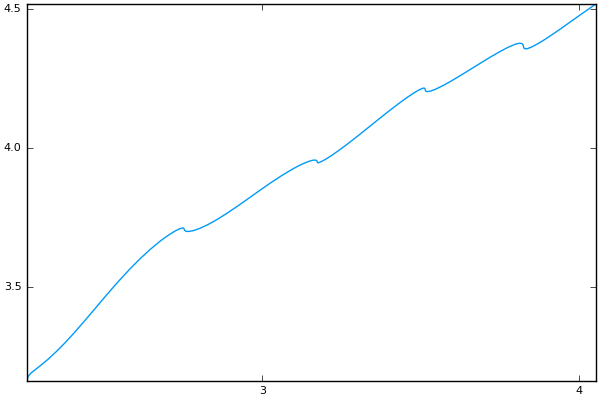

In [17]:
plot(Q11v, P11v)

In [14]:
P11v

LoadError: UndefVarError: P11v not defined